In [1]:
import json
import pandas as pd

In [2]:
# extract all latitudes and longitudes from the json file
with open('data/database.json') as f:
    data = json.load(f)
    latitudes = [float(x['LATITUDE']) for x in data]
    longitudes = [float(x['LONGITUDE']) for x in data]

In [3]:
# put into a dataframe and save as csv
df = pd.DataFrame({'latitude': latitudes, 'longitude': longitudes})
df.to_csv('postal_codes.csv', index=False)

In [6]:
df.shape

(141848, 2)

In [4]:
df.head()

,latitude,longitude
0,1.275805,103.849615
1,1.274950,103.851665
2,1.279587,103.868956
3,1.279744,103.851591
4,1.276409,103.854595


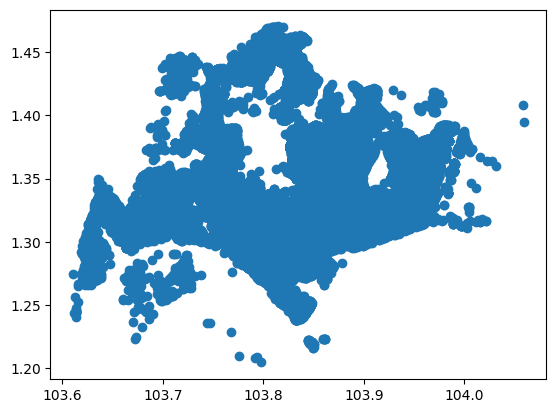

In [5]:
# do a scatter plot of df
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(df['longitude'], df['latitude'])
plt.show()